# Figure 4

In [5]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas,matplotlib

Etienne Ackermann, Fri Apr 20 2018 10:09:18 

CPython 3.6.4
IPython 6.2.1

nelpy 0.1.2
numpy 1.12.1
scipy 1.0.0
pandas 0.19.2
matplotlib 2.1.1


In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

import tabulate

from IPython.display import HTML, display, clear_output

import nelpy as nel
import nelpy.plotting as npl
import nelpy.plotting.graph as npx

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [6]:
datadirs = ['data/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'fig1.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar


In [7]:
session = '16-40-19'; segment = 'short'

In [8]:
def find_tmat_shuffle_distribution(hmm, bst, n_shuffles=3000):
    scores = []
    hmm = copy.deepcopy(hmm)

    for nn in range(n_shuffles):
        hmm.transmat_ = nel.analysis.replay.shuffle_transmat(hmm.transmat)
        scores.append(hmm.score(bst))
    
    return scores
    

In [9]:
## Train HMM for particular session using all PBEs; get VTC, and reorder both VTC and HMM states by peak firing loc on track

num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_run = 0.1
ds_50ms = 0.05
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

st = aux_data[session][segment]['st_run_noIN']
PBEs = aux_data[session][segment]['PBEs_noIN']
st_no_ripple = st[~exp_data[session]['mua_epochs']]
pos = exp_data[session]['pos1d'] # should this be pos1d? YES!

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_no_ripple = st_no_ripple.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

ext_nx=124
x0=0; xl=310;
xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

# train HMM on all training PBEs
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(PBEs)

# reorder states according to transmat ordering
transmat_order = hmm.get_state_order('transmat')
hmm.reorder_states(transmat_order)

xpos = pos.asarray(at=bst_no_ripple.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc = vtc.smooth(sigma=sigma_tc)

states_in_track_order = np.array(vtc.get_peak_firing_order_ids())-1

vtc.reorder_units(inplace=True)

hmm.reorder_states(states_in_track_order) # careful with this! VTCs and hmms can get out of sync, since state IDs are not persistent

In [13]:
def plot_Bayesian_posterior(aux_data, session, segment, PBEidx):
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
    st = aux_data[session][segment]['st_placecells_noIN']
    tc = aux_data[session][segment]['tc_noIN']
    tc_placecells = aux_data[session][segment]['tc_placecells_noIN']

    no = tc_placecells.get_peak_firing_order_ids()
    st.reorder_units_by_ids(no, inplace=True)

    st_cut = st[bst.support]
    st_cut = nel.utils.collapse_time(st_cut)

    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc, xmax=310)

    with npl.FigureManager(show=True, figsize=(3.4,2), ncols=2) as (fig, axes):
        npl.utils.skip_if_no_output(fig)

        ax, axs = axes
        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
        npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        ax.set_ylim(0,250)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle='--', color='0.8', alpha=0.4)
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks([0, bst.n_bins-1]);
        ax.set_xticklabels([1, bst.n_bins]);

        npl.utils.no_xticks(ax)
        
        ax.hlines(45, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)
        ax.hlines(225, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)

        divider = make_axes_locatable(ax)
        axRaster = divider.append_axes("top", size=0.6, pad=0)

        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=1.25, cmap=plt.cm.magma,
                    cmap_lo=0,
                    cmap_hi=0.9)
        axRaster.set_xlim(st_cut.support.time.squeeze())
        bin_edges = np.linspace(st_cut.support.time[0,0],st_cut.support.time[0,1], bst.n_bins+1)
    #     axRaster.vlines(bin_edges, *ax.get_ylim(), lw=1, linestyle=':', color='0.2')
        axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')
        npl.utils.no_xticks(axRaster)
        npl.utils.no_xticklabels(axRaster)
        npl.utils.no_yticklabels(axRaster)
        npl.utils.no_yticks(axRaster)
        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
    #     fig.suptitle('PBEs, std dev thresh=3')
        npl.utils.clear_left_right(axRaster)
        npl.utils.clear_top_bottom(axRaster)
        
    return ax, axs, fig
        

def plot_hmm_posterior(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=61, scores=None, axs_range=None):
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
        
    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = hmm.decode_ext(bst, ext_shape=(vtc.n_bins,))
    mean_pth = vtc.bins[0] + mean_pth*(vtc.bins[-1] - vtc.bins[0])
    
    score = hmm.score(bst)

    with npl.FigureManager(show=True, figsize=(3.4,0.6*2), ncols=2) as (fig, axes):
        npl.utils.skip_if_no_output(fig)

        ax, axs = axes
        
        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
        npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle='--', color='0.8', alpha=0.4)
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)
        
        if scores:
            sns.distplot(scores, hist=False, fit=stats.norm, kde=False, ax=axs)
            axs.plot(score, 0, 'o', color=npl.colors.sweet.red)

            axs.set_xlim(axs_range)
            npl.utils.xticks_interval(50)
            sns.despine(ax=axs)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks([0, bst.n_bins-1]);
        ax.set_xticklabels([1, bst.n_bins]);
        
        ax.hlines(45, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)
        ax.hlines(225, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)

        npl.utils.no_xticks(ax)

        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
        
    return ax, axs, fig
    
def plot_shuffled_posterior(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=61, scores=None, axs_range=None):
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
        
    hmm = copy.deepcopy(hmm)
    hmm.transmat_ = nel.analysis.replay.shuffle_transmat(hmm.transmat)
    
    score = hmm.score(bst)
    
    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = hmm.decode_ext(bst, ext_shape=(vtc.n_bins,))
    mean_pth = vtc.bins[0] + mean_pth*(vtc.bins[-1] - vtc.bins[0])

    with npl.FigureManager(show=True, figsize=(3.4,0.6*2), ncols=2) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        
        ax, axs = axes

        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
        npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle='--', color='0.8', alpha=0.4)
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)
        
        ax.hlines(45, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)
        ax.hlines(225, *ax.get_xlim(), lw=1, color='0.8', alpha=0.4)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)
        
        if scores:
            sns.distplot(scores, hist=False, fit=stats.norm, kde=False, ax=axs)
            axs.plot(score, 0, 'o', color=npl.colors.sweet.red)

            axs.set_xlim(axs_range)
            npl.utils.xticks_interval(50)
            sns.despine(ax=axs)
        
        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks([0, bst.n_bins-1]);
        ax.set_xticklabels([1, bst.n_bins]);

        npl.utils.no_xticks(ax)

        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
        
    return ax, axs, fig

def plot_hmm_posterior_states(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=61, scores=None, axs_range=None):
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
        
    # decode neural activity
    _, posterior = hmm.score_samples(bst)
    posterior = posterior[0]
    
    score = hmm.score(bst)

    with npl.FigureManager(show=True, figsize=(3.4,0.6*2), ncols=2) as (fig, axes):
        npl.utils.skip_if_no_output(fig)

        ax, axs = axes
        
        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(30), data=posterior, cmap=plt.cm.gray_r, ax=ax, vmin=0, vmax=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)
        
        if scores:
            sns.distplot(scores, hist=False, fit=stats.norm, kde=False, ax=axs)
            axs.plot(score, 0, 'o', color=npl.colors.sweet.red)

            axs.set_xlim(axs_range)
            npl.utils.xticks_interval(50)
            sns.despine(ax=axs)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks([0, bst.n_bins-1]);
        ax.set_xticklabels([1, bst.n_bins]);

        npl.utils.no_xticks(ax)

        ax.set_ylabel('states')
        ax.set_xlabel('time bins (20 ms)')
        
    return ax, axs, fig
    
def plot_shuffled_posterior_states(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=61, scores=None, axs_range=None):
    bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
        
    hmm = copy.deepcopy(hmm)
    hmm.transmat_ = nel.analysis.replay.shuffle_transmat(hmm.transmat)
    
    score = hmm.score(bst)
    
    # decode neural activity
    _, posterior = hmm.score_samples(bst)
    posterior = posterior[0]

    with npl.FigureManager(show=True, figsize=(3.4,0.6*2), ncols=2) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        
        ax, axs = axes

        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(30), data=posterior, cmap=plt.cm.gray_r, ax=ax, vmin=0, vmax=1)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        
        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)
        
        if scores:
            sns.distplot(scores, hist=False, fit=stats.norm, kde=False, ax=axs)
            axs.plot(score, 0, 'o', color=npl.colors.sweet.red)

            axs.set_xlim(axs_range)
            npl.utils.xticks_interval(50)
            sns.despine(ax=axs)
        
        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks([0, bst.n_bins-1]);
        ax.set_xticklabels([1, bst.n_bins]);

        npl.utils.no_xticks(ax)

        ax.set_ylabel('states')
        ax.set_xlabel('time bins (20 ms)')
        
    return ax, axs, fig

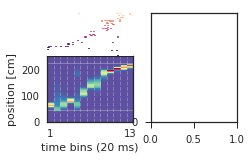

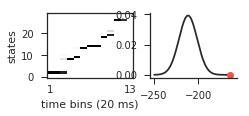

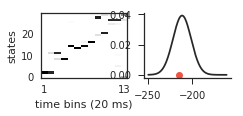

In [14]:
PBEidx = 54 # 52,53,54

bst = aux_data[session][segment]['PBEs_noIN'][PBEidx]
scores = find_tmat_shuffle_distribution(hmm, bst)

ax_b, ax_bs, f0 = plot_Bayesian_posterior(aux_data, session='16-40-19', segment='short', PBEidx=PBEidx)
ax_hmm, ax_hmms, f1= plot_hmm_posterior_states(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=PBEidx, scores=scores)
ax_shfl, ax_shfls, f2 = plot_shuffled_posterior_states(hmm, vtc, aux_data, session='16-40-19', segment='short', PBEidx=PBEidx, scores=scores)
